In [29]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
from torchvision import datasets

from src.evaluate.evaluate import evaluate
from src.train.train_model import train_model
from src.transforms.transforms import data_transforms
from src.visualization.visualize import plot_confusion_matrix
from src.visualization.visualize import imshow
from src.visualization.visualize import visualize_model


# Pipelines

## prepare configs

In [2]:
!cd .. && python src/pipelines/prepare_configs.py --config config/pipeline_config.yml

In [3]:
import yaml
config = yaml.load(open('../config/pipeline_config.yml'))

## prepare dataset

In [20]:
!cd .. && python src/pipelines/prepare_dataset.py --config=experiments/prepare_dataset_config.yml

unzip archive...


create directories...


split train images by classes...


create validation dataset...


create test dataset...


create sample dataset...


#### Show examples of image with classes

In [4]:
train_dataset = datasets.ImageFolder(os.path.join('..', config['dataset']['dataset_dir'], 'train'), data_transforms['train'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['train']['batch_size'], shuffle=True)

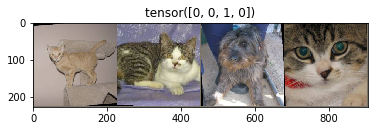

In [5]:

examples_number = 4

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
inputs, classes = inputs[:examples_number], classes[:examples_number]

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


## train model

In [21]:
!cd .. && python src/pipelines/train_model.py --config=experiments/train_model_config.yml

DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/vision-reproml, universal_newlines=False, shell=None)
DEBUG:git.cmd:Popen(['git', 'version'], cwd=/home/vision-reproml, universal_newlines=False, shell=None)
Epoch 0/2
----------
train Loss: 0.8615 Acc: 0.5000
val Loss: 0.7386 Acc: 0.5000
New best model found!
New record loss: 0.7386482357978821, previous record loss: inf

Epoch 1/2
----------
train Loss: 0.7168 Acc: 0.5000
val Loss: 0.6668 Acc: 0.5750
New best model found!
New record loss: 0.666775643825531, previous record loss: 0.7386482357978821

Epoch 2/2
----------
train Loss: 0.6534 Acc: 0.5450
val Loss: 0.6522 Acc: 0.5250
New best model found!
New record loss: 0.6521909236907959, previous record loss: 0.666775643825531

Training complete in 3m 6s
Best val Acc: 0.5250 Best val loss: 0.6522
INFO:root:data/sample image folder


## evaluate model

In [22]:
!cd .. && python src/pipelines/evaluate_model.py --config=experiments/evaluate_model_config.yml

100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.25s/it]


#### Visualize evaluation

In [12]:
model_name = os.path.join('..', config['model']['models_folder'], config['model']['model_name'])
model_name

'../models/model.pth'

In [13]:
model = torch.load(model_name)

test_dataset = datasets.ImageFolder(os.path.join('..', config['dataset']['dataset_dir'], 'test'), data_transforms['test'])
test_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=True)

class_names = test_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

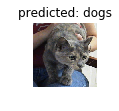

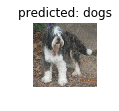

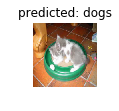

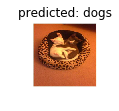

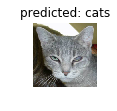

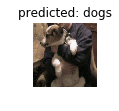

In [20]:
visualize_model(model, test_dataloader, device, class_names, 6)

In [23]:
evaluate_report_fn = os.path.join('..', config['report']['reports_folder'], '{}_evaluate_report.json'.format(config['model']['model_name']))
evaluate_report_fn

'../experiments/model.pth_evaluate_report.json'

In [24]:
evaluate_report = yaml.load(open(evaluate_report_fn))
evaluate_report

{'model_name': 'model.pth',
 'metrics': {'precision': 0.5128205128205128,
  'recall': 1.0,
  'f1': 0.6779661016949152,
  'roc_auc': 0.525,
  'confusion_matrix': [[1, 19], [0, 20]]}}

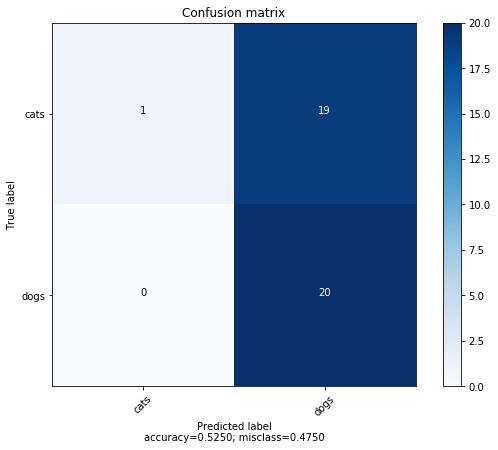

In [30]:
plot_confusion_matrix(
    np.array(evaluate_report['metrics']['confusion_matrix']),
    target_names=test_dataset.classes,
    normalize=False
)

## open mlflow ui

### http://127.0.0.1:1234